# 6章 ロジスティック回帰と分類

例6-1 独立変数がひとつのロジスティック関数をPythonで定義した例

In [ ]:
import math

def predict_probability(x, b0, b1):
    p = 1.0 / (1.0 + math.exp(-(b0 + b1 * x)))
    return p

例6-2 SymPyを使ってロジスティック関数をプロットする例

In [ ]:
from sympy import *
b0, b1, x = symbols('b0 b1 x')

p = 1.0 / (1.0 + exp(-(b0 + b1 * x)))

p = p.subs(b0,-2.823)
p = p.subs(b1, 0.620)
p

1.0/(1.0 + 16.8272567955368*exp(-0.62*x))

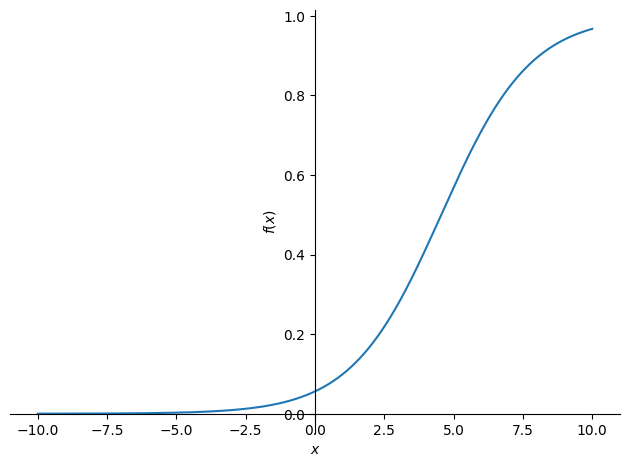

In [ ]:
plot(p);

例6-3 scikit-learnで基本的なロジスティック回帰を実行する例

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression

# データを読み込む
df = pd.read_csv('https://bit.ly/33ebs2R', delimiter=",")

# 入力変数（すべての行、最終列を除くすべての列）を抽出する
X = df.values[:, :-1]

# 出力列（すべての行、最終列）を抽出する
Y = df.values[:, -1]

# ロジスティック回帰を実行する
# （ペナルティをNone）
model = LogisticRegression(penalty=None)
model.fit(X, Y)

# beta1を表示する
print(model.coef_.flatten())
# beta0を表示する
print(model.intercept_.flatten())

[0.69268939]
[-3.17580504]


例6-4 ロジスティック回帰モデルに対してすべてのデータポイントを観測する結合尤度を求める例

In [ ]:
import math
import pandas as pd

patient_data = pd.read_csv('https://bit.ly/33ebs2R', delimiter=",").itertuples()

b0 = -3.17580504
b1 = 0.69268939

def logistic_function(x):
    p = 1.0 / (1.0 + math.exp(-(b0 + b1 * x)))
    return p

# 結合尤度を求める
joint_likelihood = 1.0

for p in patient_data:
    if p.y == 1.0:
        joint_likelihood *= logistic_function(p.x)
    elif p.y == 0.0:
        joint_likelihood *= (1.0 - logistic_function(p.x))

joint_likelihood

4.7911179961180726e-05

例6-5 結合尤度の計算を`if`式がない形に小さくまとめる

In [ ]:
import math
import pandas as pd

patient_data = pd.read_csv('https://bit.ly/33ebs2R', delimiter=",").itertuples()

b0 = -3.17580504
b1 = 0.69268939

def logistic_function(x):
    p = 1.0 / (1.0 + math.exp(-(b0 + b1 * x)))
    return p

# 結合尤度を求める
joint_likelihood = 1.0

for p in patient_data:
    joint_likelihood *= logistic_function(p.x) ** p.y * \
                        (1.0 - logistic_function(p.x)) ** (1.0 - p.y)

joint_likelihood

4.7911179961180726e-05

例6-6 対数の足し算（加法）を使った例

In [ ]:
import math
import pandas as pd

patient_data = pd.read_csv('https://bit.ly/33ebs2R', delimiter=",").itertuples()

b0 = -3.17580504
b1 = 0.69268939

def logistic_function(x):
    p = 1.0 / (1.0 + math.exp(-(b0 + b1 * x)))
    return p

# 結合尤度を求める
joint_likelihood = 0.0

for p in patient_data:
    joint_likelihood += math.log(logistic_function(p.x) ** p.y * \
                                 (1.0 - logistic_function(p.x)) ** (1.0 - p.y))

joint_likelihood = math.exp(joint_likelihood)
joint_likelihood

4.791117996118085e-05

例6-7 SymPyでロジスティック回帰の結合尤度を求める関数の例

In [ ]:
from sympy import *

m = Symbol('m')
b = Symbol('b')
x = Function('x')
y = Function('y')
i = Symbol('i')
n = Symbol('n')

joint_likelihood = Sum(log((1.0 / (1.0 + exp(-(b + m * x(i)))))**y(i) * \
	(1.0 - (1.0 / (1.0 + exp(-(b + m * x(i))))))**(1-y(i))), (i, 0, n))

joint_likelihood

Sum(log((1.0/(exp(-b - m*x(i)) + 1.0))**y(i)*(1.0 - 1.0/(exp(-b - m*x(i)) + 1.0))**(1 - y(i))), (i, 0, n))

例6-8 ロジスティック回帰に勾配降下法を使う例

In [ ]:
from sympy import *
import pandas as pd

points = list(pd.read_csv("https://tinyurl.com/y2cocoo7").itertuples())

b1, b0, i, n = symbols('b1 b0 i n')
x, y = symbols('x y', cls=Function)
joint_likelihood = Sum(log((1.0 / (1.0 + exp(-(b0 + b1 * x(i))))) ** y(i) \
    * (1.0 - (1.0 / (1.0 + exp(-(b0 + b1 * x(i)))))) ** (1 - y(i))), (i, 0, n))

# データの点を代入し、beta1（傾き）の偏微分を求める
d_b1 = diff(joint_likelihood, b1) \
           .subs(n, len(points) - 1).doit() \
           .replace(x, lambda i: points[i].x) \
           .replace(y, lambda i: points[i].y)

# データの点を代入し、beta0（切片）の偏微分を求める
d_b0 = diff(joint_likelihood, b0) \
           .subs(n, len(points) - 1).doit() \
           .replace(x, lambda i: points[i].x) \
           .replace(y, lambda i: points[i].y)

# lambdify関数でコンパイルして計算を高速化する
d_b1 = lambdify([b1, b0], d_b1)
d_b0 = lambdify([b1, b0], d_b0)

# 勾配降下法を実行する
b1 = 0.01
b0 = 0.01
L = 0.01

for j in range(10_000):
    b1 += d_b1(b1, b0) * L
    b0 += d_b0(b1, b0) * L

print(b1, b0)

0.6926693075370812 -3.175751550409821


例6-9 従業員データを使って多変数ロジスティック回帰を実行する例

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression

employee_data = pd.read_csv("https://tinyurl.com/y6r7qjrp")

# 独立変数のカラムを取得する
inputs = employee_data.iloc[:, :-1]

# 従属変数"did_quit"のカラムを取得する
output = employee_data.iloc[:, -1]

# ロジスティック回帰を構築する
fit = LogisticRegression(penalty=None).fit(inputs, output)

# 係数を出力する
print("COEFFICIENTS: {0}".format(fit.coef_.flatten()))
print("INTERCEPT: {0}".format(fit.intercept_.flatten()))

# 対話型のUIで新しい従業員のデータに対して予測する
def predict_employee_will_stay(sex, age, promotions, years_employed):
    prediction = fit.predict([[sex, age, promotions, years_employed]])
    probabilities = fit.predict_proba([[sex, age, promotions, years_employed]])
    if prediction == [[1]]:
        return "WILL LEAVE: {0}".format(probabilities)
    else:
        return "WILL STAY: {0}".format(probabilities)

# 予測をテストする
while True:
    n = input("Predict employee will stay or leave {sex}, \
        {age},{promotions},{years employed}: ")
    (sex, age, promotions, years_employed) = n.split(",")
    print(predict_employee_will_stay(int(sex), int(age), int(promotions),
          int(years_employed)))

COEFFICIENTS: [ 0.03216406  0.03683015 -2.50414078  0.97423186]
INTERCEPT: [-2.73503153]
Predict employee will stay or leave {sex},         {age},{promotions},{years employed}: 1,34,1,5


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


WILL LEAVE: [[0.28569689 0.71430311]]


例6-10 適合度（当てはめ具合）の対数尤度を求める例

In [ ]:
from math import log, exp
import pandas as pd

patient_data = pd.read_csv('https://bit.ly/33ebs2R', delimiter=",").itertuples()

b0 = -3.17580504
b1 = 0.69268939

def logistic_function(x):
    p = 1.0 / (1.0 + exp(-(b0 + b1 * x)))
    return p

# 対数尤度を合計する
log_likelihood_fit = 0.0

for p in patient_data:
    if p.y == 1.0:
        log_likelihood_fit += log(logistic_function(p.x))
    elif p.y == 0.0:
        log_likelihood_fit += log(1.0 - logistic_function(p.x))

log_likelihood_fit

-9.946161678669105

例6-11 対数尤度の処理を1行にまとめた例

In [ ]:
from math import log, exp
import pandas as pd

patient_data = pd.read_csv('https://bit.ly/33ebs2R', delimiter=",").itertuples()

b0 = -3.17580504
b1 = 0.69268939

def logistic_function(x):
    p = 1.0 / (1.0 + exp(-(b0 + b1 * x)))
    return p

# 対数尤度を合計する（1行にまとめる）
log_likelihood_fit = sum(log(logistic_function(p.x)) * p.y +
                         log(1.0 - logistic_function(p.x)) * (1.0 - p.y)
                         for p in patient_data)

log_likelihood_fit

-9.946161678669105

例6-12 患者の対数尤度を求める例

In [ ]:
import pandas as pd
from math import log

patient_data = list(pd.read_csv('https://bit.ly/33ebs2R', delimiter=",") \
     .itertuples())

likelihood = sum(p.y for p in patient_data) / len(patient_data)

log_likelihood = 0.0

for p in patient_data:
    if p.y == 1.0:
        log_likelihood += log(likelihood)
    elif p.y == 0.0:
        log_likelihood += log(1.0 - likelihood)

log_likelihood

-14.341070198709906

例6-13 対数尤度の計算を1行にまとめる例

In [ ]:
import pandas as pd
from math import log

patient_data = list(pd.read_csv('https://bit.ly/33ebs2R', delimiter=",") \
     .itertuples())

likelihood = sum(p.y for p in patient_data) / len(patient_data)

log_likelihood = sum(log(likelihood)*p.y + log(1.0 - likelihood)*(1.0 - p.y) \
    for p in patient_data)

log_likelihood

-14.341070198709906

例6-14 ロジスティック回帰の$R^2$を求める例

In [ ]:
import pandas as pd
from math import log, exp

patient_data = list(pd.read_csv('https://bit.ly/33ebs2R', delimiter=",") \
                                .itertuples())

# ロジスティック回帰の係数
b0 = -3.17580504
b1 = 0.69268939

def logistic_function(x):
    p = 1.0 / (1.0 + exp(-(b0 + b1 * x)))
    return p

# 適合度の対数尤度を求める
log_likelihood_fit = sum(log(logistic_function(p.x)) * p.y +
                         log(1.0 - logistic_function(p.x)) * (1.0 - p.y)
                         for p in patient_data)

# 対数尤度を求める
likelihood = sum(p.y for p in patient_data) / len(patient_data)

log_likelihood = sum(log(likelihood) * p.y + log(1.0 - likelihood) * (1.0 - p.y) \
    for p in patient_data)
log_likelihood

-14.341070198709906

In [ ]:
# 決定係数R^2を求める
r2 = (log_likelihood - log_likelihood_fit) / log_likelihood
r2

0.30645610537741863

例6-15 ロジスティック回帰のp値を求める例

In [ ]:
import pandas as pd
from math import log, exp
from scipy.stats import chi2

patient_data = list(pd.read_csv('https://bit.ly/33ebs2R', delimiter=",").itertuples())

# ロジスティック回帰の係数
b0 = -3.17580504
b1 = 0.69268939

def logistic_function(x):
    p = 1.0 / (1.0 + exp(-(b0 + b1 * x)))
    return p

# 適合度の対数尤度を求める
log_likelihood_fit = sum(log(logistic_function(p.x)) * p.y +
                         log(1.0 - logistic_function(p.x)) * (1.0 - p.y)
                         for p in patient_data)

# 対数尤度を求める
likelihood = sum(p.y for p in patient_data) / len(patient_data)

log_likelihood = sum(log(likelihood) * p.y + log(1.0 - likelihood) * (1.0 - p.y) \
                     for p in patient_data)

# p値を求める
chi2_input = 2 * (log_likelihood_fit - log_likelihood)
p_value = chi2.pdf(chi2_input, 1) # 自由度は1とする（n - 1）

print(p_value)

0.0016604875719315217


例6-16 三分割の交差検証でロジスティック回帰を実行する例

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score

# データを読み込む
df = pd.read_csv("https://tinyurl.com/y6r7qjrp", delimiter=",")

X = df.values[:, :-1]
Y = df.values[:, -1]

kfold = KFold(n_splits=3, random_state=7, shuffle=True)
model = LogisticRegression(penalty=None)
results = cross_val_score(model, X, Y, cv=kfold)

print("Accuracy Mean: %.3f (stdev=%.3f)" % (results.mean(), results.std()))

Accuracy Mean: 0.611 (stdev=0.000)


例6-17 scikit-learnでテスト用データセットの混同行列を生成する例

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# データを読み込む
df = pd.read_csv('https://bit.ly/3cManTi', delimiter=",")

# 入力変数（すべての行、最終列を除くすべての列）を抽出する
X = df.values[:, :-1]

# 出力列（すべての行、最終列）を抽出する
Y = df.values[:, -1]

model = LogisticRegression(solver='liblinear')

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33,
    random_state=10)
model.fit(X_train, Y_train)
prediction = model.predict(X_test)

"""
混同行列は、それぞれの観点で精度を評価する。
[[TP（真陽性） FN（偽陰性）]
 [FP（偽陽性） TN（真陰性）]]

左上から右下の対角線上の値は、予測が正しいことを示すため、
高いほどよい。
"""
matrix = confusion_matrix(y_true=Y_test, y_pred=prediction)
matrix


array([[6, 3],
       [4, 5]])

In [ ]:
matrix_df = pd.DataFrame(matrix, index=['Actual Positive', 'Actual Negative'], columns=['Predicted Positive', 'Predicted Negative'])
matrix_df

,Predicted Positive,Predicted Negative
Actual Positive,6,3
Actual Negative,4,5


例6-18 scikit-learnでAUCをパラメータに設定する例

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score

# データを読み込む
df = pd.read_csv("https://tinyurl.com/y6r7qjrp", delimiter=",")

X = df.values[:, :-1]
Y = df.values[:, -1]

kfold = KFold(n_splits=3, random_state=7, shuffle=True)
model = LogisticRegression(penalty=None)

# AUCを使ってスコアリングする
results = cross_val_score(model, X, Y, cv=kfold, scoring='roc_auc')
print("AUC: %.3f (%.3f)" % (results.mean(), results.std()))

AUC: 0.814 (0.056)


例6-19 scikit-learnの`stratify`オプションを使ってクラス分布を維持する例例

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split

# データを読み込む
df = pd.read_csv("https://tinyurl.com/y6r7qjrp", delimiter=",")

X = df.values[:, :-1]
Y = df.values[:, -1]

X_train, X_test, Y_train, Y_test =  \
    train_test_split(X, Y, test_size=0.33, stratify=Y)

model = LogisticRegression(penalty=None)
model.fit(X_train, Y_train)

Y_pred_prob = model.predict_proba(X_test)[:, 1]

# AUCを使ってスコアリングする
auc_score = roc_auc_score(Y_test, Y_pred_prob)
print("AUC: %.3f" % auc_score)

AUC: 0.963
